In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import scipy
import tensorflow as tf

In [2]:
def streamingCCA(X,Y,n):
    
    length,m = X.shape
    
    a = np.random.randn(m,n)
    a,_ = np.linalg.qr(a, mode='reduced')
    b = np.random.randn(m,n)
    b,_ = np.linalg.qr(b, mode='reduced')
    
    corr_list = np.zeros((n,100))
    
    covx = np.zeros((m,m))
    covy = np.zeros((m,m))
    
    eta1 = 0.0015
    eta2 = 0.0015
    for j in range(0,100):
        for i in range(500):
    
            ind = j*100+i
            x = X[ind,:]
            y = Y[ind,:]
    
            c12 = np.outer(x,y)
            
            covx = (covx*ind+np.outer(x,x))/(ind+1)#covariance C_xx
            covy = (covy*ind+np.outer(y,y))/(ind+1)#covariance C_yy
            
            a += eta1*c12@b
            a,ar = np.linalg.qr(a, mode='reduced')            
            for k in range(n):
                a[:,k] = a[:,k]/np.sqrt(a[:,k].T@covx@a[:,k])
            a = a*np.sign(np.diagonal(ar))
    
            b += eta2*c12.T@a
            b,br = np.linalg.qr(b, mode='reduced')
            for k in range(n):
                b[:,k] = b[:,k]/np.sqrt(b[:,k].T@covy@b[:,k])
            b = b*np.sign(np.diagonal(br))
    
        X_s = X@a
        Y_s = Y@b    
        for k in range(n):
            corr_list[k,j] = np.corrcoef(X_s.T,Y_s.T)[n+k,k]

        
    return a,b,corr_list

In [3]:
'''
l1 = np.random.normal(size=100000)
l2 = np.random.normal(size=100000)
l3 = np.random.normal(size=100000)

latents = np.array([l1, l1*0.5, l1*0.25, l2*0.7, l2*0.3, l3*0.5]).T
X = latents + np.random.normal(size=6 * 100000).reshape((100000, 6))*0.5
Y = latents + np.random.normal(size=6 * 100000).reshape((100000, 6))*0.5

X = X-X.mean(axis=0)
Y = Y-Y.mean(axis=0)
'''

'\nl1 = np.random.normal(size=100000)\nl2 = np.random.normal(size=100000)\nl3 = np.random.normal(size=100000)\n\nlatents = np.array([l1, l1*0.5, l1*0.25, l2*0.7, l2*0.3, l3*0.5]).T\nX = latents + np.random.normal(size=6 * 100000).reshape((100000, 6))*0.5\nY = latents + np.random.normal(size=6 * 100000).reshape((100000, 6))*0.5\n\nX = X-X.mean(axis=0)\nY = Y-Y.mean(axis=0)\n'

In [4]:
x = tf.keras.datasets.cifar10.load_data()[0][0]
x = x.reshape(-1,32*32*3)
x = x/255
x = (x - x.mean(axis=0))
X = x[:,:10]
Y = x[:,-10:]

In [5]:
n=3
a,b,corr_list = streamingCCA(X, Y, n)
cca = CCA(n_components=n,max_iter=60000)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

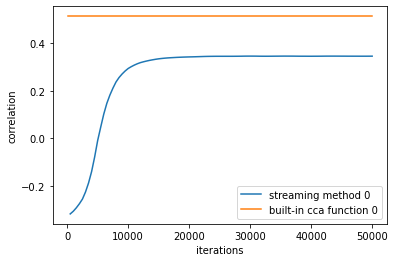

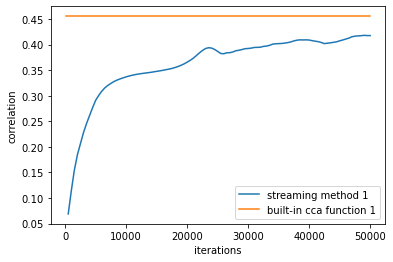

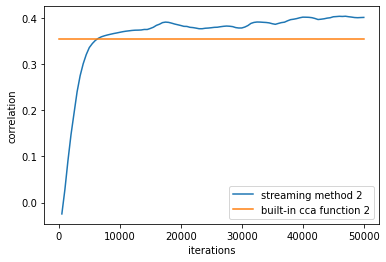

In [6]:
for i in range(n):
    plt.plot(np.array(list(range(1,101)))*500,corr_list[i,:],label='streaming method {}'.format(i))
    plt.plot([100,50000],[np.corrcoef(X_c.T,Y_c.T)[n+i,i],np.corrcoef(X_c.T,Y_c.T)[n+i,i]],label='built-in cca function {}'.format(i))
    plt.xlabel('iterations')
    plt.ylabel('correlation')
    plt.legend()
    plt.show()